# Teched 2022 DA180 Workshop - Ex5 Apply Forecasting to multi-model data

In this exercise, we want to apply SAP HANA Cloud multi-model processing techniques to prepare assemble geo-located fuel station data of Germany, and apply segmented forecasting techniques using the [Predictive Analysis Library (PAL)]() to build and apply forecast models for each station's "e5" car fuel price.

The exercise is composed from the perspective of a Data Scientist working in a Python (Juypter Notebook) environment, leveraging the [Python Machine Learning client for SAP HANA](https://help.sap.com/doc/1d0ebfe5e8dd44d09606814d83308d4b/latest/en-US/index.html). For reference information regarding the setup and configuration of your Python environment see [Appendix].  
  
  The objective and goal for this exercise is
- in ex 5.1 to download the stations and regions geo-data, save them in SAP HANA CLoud, apply HANA-spatial filtering of the data and visualize it
- in ex 5.2 to download the fuel price data, save it to SAP HANA Cloud and explore (visually) the time series data
- in ex 5.3 to build forecast models on the spatially filtered stations, apply and visualize the predicted fuel price data.

As an extra and optional exercise, the [add-on section]() describes how to evaluate the forecast model accuracy for all stations forecast models.  

You can approach the exercises by  copy & paste of the Python code snippets from this document or open the Jupyter Notebook file provided [here]().

# Preparation steps in your Python Jupyter Notebook

## Import the requied python packages

In [1]:
# Import HANA-ML package and check version (should be 2.14.22101400 or newer)
import hdbcli
import hana_ml
from hana_ml import dataframe
from hana_ml.dataframe import create_dataframe_from_pandas, create_dataframe_from_shapefile

# Import additional packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon

print(hana_ml.__version__)

2.14.22101400


## Connect to SAP HANA Cloud database

In [ ]:
# Provide your SAP HANA Cloud connection details
host = '[YourHostName]'
port = 443
user = '[YourUser]'
passwd = '[YourUserPassword]'

In [3]:
# Establish the SAP HANA Cloud connection as "conn"
conn= dataframe.ConnectionContext(address=host, port=port, user=user, password=passwd,
                               encrypt='true' ,sslValidateCertificate='false')

In [3]:
#conn = dataframe.ConnectionContext( address="<machine>", port=<SQL-port>,  user="<HANA-user>", password="<password>")
hc_url = '859c0f95-60f9-4540-aa81-581a8e452c6f.hna1.canary-eu10.hanacloud.ondemand.com'
conn = dataframe.ConnectionContext( address=hc_url, port=443, user="TECHED_USER_999", password='TechEd22Welcome' )
conn.hana_version()

'4.00.000.00.1663064250 (fa/CE2022.30)'

# Ex 5.1 - Load, prepare and explore fuel station datasets

__Preparation Step - file downloads__

Note, the data used along with the exercises is thereas used only for the purpose of your personal education, for details about the use case data sources and licenses see the [reference section]()  

Download the following files to your project directory ./teched2022-DA180/data/fuelprice
- Germany Landkreise regions shapefile from [here](https://data.opendatasoft.com/explore/dataset/georef-germany-kreis@public/download/?format=shp&timezone=Europe/Berlin&lang=en) and save it to ./data/fuelprice/
- Germany fuel station data set from [here](https://dev.azure.com/tankerkoenig/_git/tankerkoenig-data?path=/stations/stations.csv) and save it to ./data/fuelprice/
- Germany fuel price September 2022 data (or multiple months) from [here](https://dev.azure.com/tankerkoenig/_git/tankerkoenig-data?path=/prices/2022/09) as ZIP-download and extract the ZIP-file to a subfolder per month like ./data/fuelprice/09  

<br>
Your project data directory would look like

In [11]:
#!ls data/fuelprice
!dir data\\fuelprice

 Volume in drive C is OSDisk
 Volume Serial Number is 72BC-6B0D

 Directory of C:\Users\D059078\OneDrive - SAP SE\Documents\D059078_Docs\_Projekte\python\PythonNotebooks\##events\#22TE\teched2022-DA180\data\fuelprice

14.10.2022  10:31    <DIR>          .
14.10.2022  10:31    <DIR>          ..
05.10.2022  16:46    <DIR>          06
08.10.2022  13:10    <DIR>          07
08.10.2022  14:03    <DIR>          08
13.10.2022  19:09    <DIR>          09
02.10.2022  09:32         5,542,990 georef-germany-kreis.zip
13.10.2022  16:51         1,880,990 stations.csv
09.10.2022  21:35           851,909 stations_hwaydist.csv
               3 File(s)      8,275,889 bytes
               6 Dir(s)  410,278,199,296 bytes free


__Step 1 - Import the fuel stations data__  
Execute the following Python code to import the stations.csv-file into your HANA system
- Note, replace TECHED_USER_### with your specific / assinged HANA system userid or schema.

In [5]:
# load gas station data from csv
stations_pd = pd.read_csv('./data/fuelprice/stations.csv', sep=',', header=None, skiprows=1,
                          names=["uuid","name", "brand", "street","house_number",
                                  "post_code", "city", "latitude", "longitude"])

# create hana dataframe/DB table from pandas dataframe
stations_hdf = create_dataframe_from_pandas(
        conn,
        stations_pd,
        schema='TECHED_USER_999',
        table_name="GAS_STATIONS",
        force=True,
        replace=True,
        drop_exist_tab=False,
        geo_cols=[("longitude", "latitude")], srid=4326
    )

print("There are", stations_hdf.count(), "service stations in Germany", "\n")

stations_hdf.head(2).collect()

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


There are 15442 service stations in Germany 



,uuid,name,brand,street,house_number,post_code,city,latitude,longitude,longitude_latitude_GEO
0,00060723-0001-4444-8888-acdc00000001,BAGeno Raiffeisen eG,None,Künzelsauer Strasse,7,74653,Ingelfingen,49.296822,9.661385,POINT (9.661384582519501 49.296821594238)
1,005056ba-7cb6-1ed2-bceb-5332ab168d12,famila Tankstelle,FAMILA,Pascalstrasse,9,25442,Quickborn,53.742150,9.941240,POINT (9.941239999999999 53.74215)


<br>  

__Step 2 - Import the Germany "Landkreise"-regions shapefile__  
Execute the following lines of python code to import the Germany "Landkreise" regional areas shapefile.  
- Note, replace TECHED_USER_### with your specific / assinged HANA system userid or schema.

In [12]:
# create dataframe from shapefile for german regions "Landreise"
regions_hdf = create_dataframe_from_shapefile(
  connection_context=conn,
  shp_file='./data/fuelprice/georef-germany-kreis.zip',
  srid=25832,
  schema='TECHED_USER_999',
  table_name="GEO_GERMANY_REGIONS")

regions_hdf.drop('year').head(5).collect()

,lan_code,lan_name,krs_code,krs_name,krs_area_co,krs_type,krs_name_sh,SHAPE
0,03,Niedersachsen,03460,Landkreis Vechta,DEU,Landkreis,Vechta,"POLYGON ((8.459274000000001 52.801056, 8.4603 ..."
1,09,Bayern,09671,Landkreis Aschaffenburg,DEU,Landkreis,Aschaffenburg,"POLYGON ((9.40498 50.08774, 9.402760000000001 ..."
2,03,Niedersachsen,03155,Landkreis Northeim,DEU,Landkreis,Northeim,"(POLYGON ((9.8949 51.90616, 9.89282 51.905075,..."
3,03,Niedersachsen,03451,Landkreis Ammerland,DEU,Landkreis,Ammerland,"POLYGON ((8.173920000000001 53.35404, 8.167730..."
4,05,Nordrhein-Westfalen,05978,Kreis Unna,DEU,Kreis,Unna,"POLYGON ((7.40955 51.66458, 7.41054 51.663895,..."


<br>
<br>  

 __Step 3 - Use SAP HANA spatial operations to filter stations__  
 Use SAP HANA spatial intersection-function to filter the fuel stations in Germany to those close to SAP Headquarters "Landkreise"-regions of "Rhein-Neckar-Kreis", Mannheim and Heidelberg.

In [7]:
# filter service stations in Germany using SAP HANA spatial intersect-function
stations_rnk_hdf = stations_hdf.join(regions_hdf, 
  '"longitude_latitude_GEO".ST_SRID(25832).st_transform(25832).st_intersects(SHAPE)=1').filter(
  "\"krs_name\"='Landkreis Rhein-Neckar-Kreis' or \"krs_name\"='Stadtkreis Heidelberg' or \"krs_name\"='Stadtkreis Mannheim'"
  )

# Show the SQL statement for the HANA dataframe "stations_rnk_hdf"
print(stations_rnk_hdf.select_statement, "\n")

# Show the number of service stations in selected spatial area
print("Number of Serice Stations in the Rhein-Neckar area", stations_rnk_hdf.count())

SELECT * FROM (SELECT * FROM (SELECT "uuid", "name", "brand", "street", "house_number", "post_code", "city", "latitude", "longitude", "longitude_latitude_GEO" FROM (SELECT * FROM "TECHED_USER_999"."GAS_STATIONS") dt) AS "DT_6" INNER JOIN (SELECT * FROM "TECHED_USER_999"."GEO_GERMANY_REGIONS") AS "DT_11" ON "longitude_latitude_GEO".ST_SRID(25832).st_transform(25832).st_intersects(SHAPE)=1) AS "DT_14" WHERE "krs_name"='Landkreis Rhein-Neckar-Kreis' or "krs_name"='Stadtkreis Heidelberg' or "krs_name"='Stadtkreis Mannheim' 

Number of Serice Stations in the Rhein-Neckar area 171


<br>  

__Step 4 - Visualize the stations on a map in Python__  
First we spatially filter the remaining fuel stations into another HANA dataframe.

In [8]:
# filter service stations in Germany to those NOT within the "Rhein-Neckar-Kreis"-region
stations_GER_hdf = stations_hdf.join(regions_hdf, 
 '"longitude_latitude_GEO".ST_SRID(25832).st_transform(25832).st_intersects(SHAPE)=1').filter(
 "\"krs_name\"!='Landkreis Rhein-Neckar-Kreis' AND \"krs_name\"!='Stadtkreis Heidelberg' AND \"krs_name\"!='Stadtkreis Mannheim'"
 )

# Count the number of service stations in Germany, excluding the ones selected around the SAP Headquarters and area
print("Number of Service Stations in Germany, excluding the one in 'Rhein-Neckar-Kreis'-region",stations_GER_hdf.count())

Number of Service Stations in Germany, excluding the one in 'Rhein-Neckar-Kreis'-region 15263


Then for the visualization, we collect the regions-shape and fuel station point data into __geopandas__ dataframes. This step may run for more than a minute.

In [9]:
#%%time
#Wall time: 3min 30s

# Collecting the HANA dataframe fuel stations point location spatial data for visualization into geopandas dataframes
stations_rnk_pd = stations_rnk_hdf.collect()
stations_rnk_geopands = gpd.GeoDataFrame(
    stations_rnk_pd, geometry=gpd.points_from_xy(stations_rnk_pd.longitude, stations_rnk_pd.latitude))

stations_GER_pd = stations_GER_hdf.collect()
stations_GER_geopands = gpd.GeoDataFrame(
    stations_GER_pd, geometry=gpd.points_from_xy(stations_GER_pd.longitude, stations_GER_pd.latitude))

# Collecting the HANA dataframe Germany region spatial data for visualization into a geopandas dataframe
regions_pd = regions_hdf.collect()
regions_geopands = gpd.GeoDataFrame(regions_pd, geometry='SHAPE')

<br>
We can now create a map plot of stations and regions with this Python code  


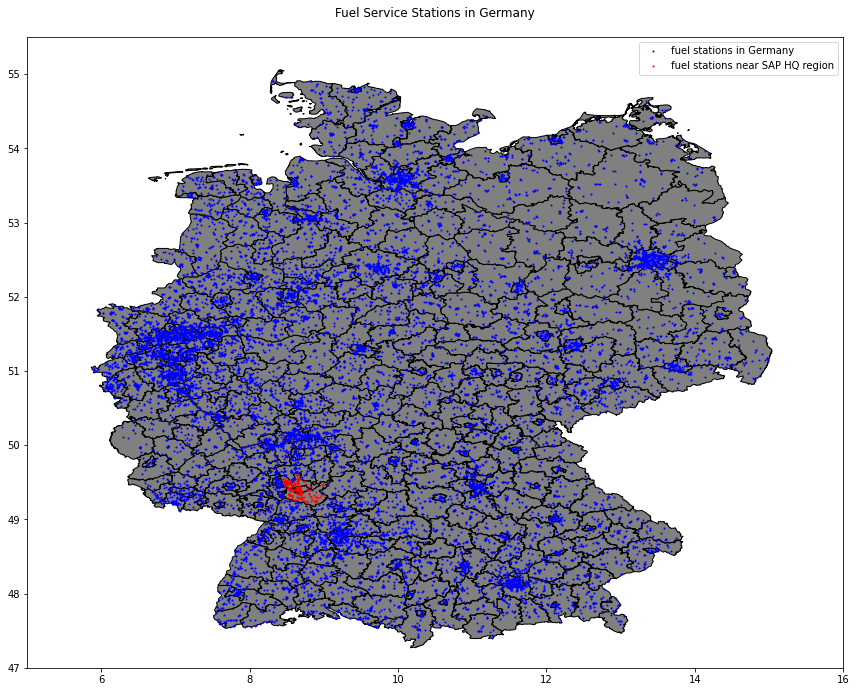

In [10]:
#Plot gepandas dataframes 
fig, ax = plt.subplots(figsize=(12,12))
ax.set_xlim((5,16))
ax.set_ylim((47,55.5))

regions_geopands.plot(ax=ax, facecolor='Grey', edgecolor='k')
stations_GER_geopands.plot(ax=ax, marker='.',  color='blue', markersize=4, label='fuel stations in Germany ')
stations_rnk_geopands.plot(ax=ax, marker='.',  color='red', markersize=4, label='fuel stations near SAP HQ region')

ax.legend()
ax.set_title('Fuel Service Stations in Germany', pad=20)
fig = ax.get_figure()
fig.tight_layout()

#  Exercise 5.2 - Load, prepare and explore fuel price datasets



__Step 1 - Import fuel price csv-files__  
With the following step, you can import all csv-files from a local folder into a single HANA table represented by a HANA dataframe using the __createcreate_dataframe_from_pandas__ method.   
Here it is assumed that each months data is located in one folder.
The demo screenshots show may be based on downloaded data for multiple months in 2022 and thus may differ if you only downloaded the September 2022 data.

In [46]:
# Retrieve hana fuel price csv-file name into a Python list
mypath='./data/fuelprice/09/09'
from os import listdir
from os.path import isfile, join
pricefiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
#pricefiles

# load fuel price data for the 
gp_tmp_pd = {}
for file in pricefiles:
    gp_tmp_pd[file] = pd.read_csv('./data/fuelprice/09/09/{}'.format(file), sep=',', header=0, skiprows=1,
                                      names=["date", "station_uuid", "diesel", "e5", "e10", "dieselchange", "e5change", "e10change"],
                                      usecols=["date", "station_uuid", "diesel", "e5", "e10", "dieselchange", "e5change", "e10change"])
    fuelprices_hdf = create_dataframe_from_pandas(
        conn, gp_tmp_pd[file],
        schema='TECHED_USER_999', table_name="GAS_PRICES",
        append=True,
        table_structure={"date": "TIMESTAMP", "station_uuid": "NVARCHAR(5000)", 
                         "diesel": "DOUBLE", "e5": "DOUBLE", "e10": "DOUBLE",
                         "dieselchange" : "INTEGER","e5change" : "INTEGER","e10change" : "INTEGER"})
    
# Show row count for uploaded fuel price data
gasprices_hdf.count()

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:11<00:00,  1.48s/it]


10575771

<br>

__Step 2 - Analyse and explore the fuel price data__  
Use HANA dataframe methods to display and count the number of rows in the HANA table.

In [15]:
# create hana dataframe including all gas prices in Germany in 2022 uploaded
fuelprice_all_hdf = conn.sql('select * from "RAW_DATA"."GAS_PRICES"')
#fuelprice_all_hdf = conn.sql('select * from "TECHED_USER_999"."GAS_PRICES"')
fuelprices_hdf=fuelprice_all_hdf
print("There are", fuelprices_hdf.count(), "records in the dataset", "\n")

fuelprices_hdf.sort('date', desc=True).head(3).collect()

There are 90931410 records in the dataset 



,date,station_uuid,diesel,e5,e10,dieselchange,e5change,e10change
0,2022-09-30 23:59:09,51ba10bc-cefc-4544-88e8-0d830b11e961,2.099,1.999,1.939,1,1,1
1,2022-09-30 23:59:09,5a218a69-d93f-446a-99e4-79ed9b5d5183,1.989,1.879,1.859,0,1,1
2,2022-09-30 23:59:09,1674639b-579b-49ea-8e6b-7ad8d75c38e0,1.999,1.879,1.829,1,1,1


Note, the rowcount output for September would be 10.575.771, or at 90.931.410 if January-September data was loaded.
<br>
<br>
Now, lets focus on the __analysis of the E5 car fuel data__.  
E5 petrol is the standard car fuel in Europe, made up of 95% unleaded petrol plus 5% ethanol.

In [16]:
# Selecting columns in focus, creating a derived dataframe "fuelprice_all_hdf"
fuelprice_all_hdf=fuelprices_hdf.select('date', 'station_uuid', 'e5')
#display(fuelprice_all_hdf.head(3).collect())

# Count the price changes per fuel service station using HANA dataframe group-by aggregation method
display(fuelprice_all_hdf.agg([('count', 'e5', 'N')], group_by='station_uuid').collect())

,station_uuid,N
0,436782d2-cf94-408c-9715-693f0be4b091,5579
1,a1ea6437-ddbc-4f1c-a5bb-2b5fa33f8e7e,6817
2,a19a5477-304e-4a99-adc5-3b2282c11297,2822
3,3aeed500-8dda-4bd8-be55-d13e415e81b1,6477
4,7221415e-d627-40c6-be7f-285cf6744492,11584
...,...,...
15297,e1a15081-24db-9107-e040-0b0a3dfe563c,8269
15298,a1b585de-8277-4162-bccd-58e363fa7367,5376
15299,c6ea4fa6-8e77-4836-adc1-68adccda8f5d,6977
15300,8fa70ebd-27ca-43ff-8345-d1f380cb5501,5237


Note, the row counts shown are derived from 7 months of fuel price data.

<br>

Next we want to visually __explore the e5 price data using a distribution histogram__, allowing us to identify outlier data ranges.

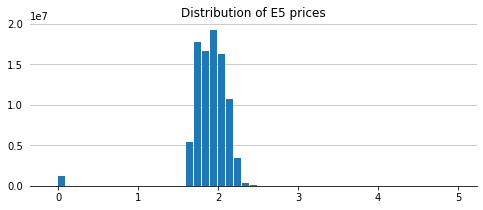

In [17]:
# Plot a HANA-ML Distribution Histogram (incl. value binnning)
from hana_ml.visualizers.eda import EDAVisualizer
f = plt.figure(figsize=(8,3))
ax1 = f.add_subplot(111)

eda = EDAVisualizer(ax1)
ax, dist_data = eda.distribution_plot( data=fuelprice_all_hdf, column="e5", bins=50, 
                                      title="Distribution of E5 prices", debrief=False)
plt.show()

It appears as if there is price data ranging from near 0€ until up to 5€ per liter.  
Thus let's filter the price data using the HANA dataframe-filter method.

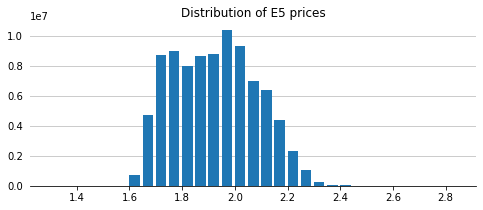

In [44]:
# Filter outliers
fuelprice_all_hdf=fuelprice_all_hdf.filter('"e5" > 1.3 and "e5"< 2.8')

# Re-run Distribution Histogram (incl. binnning)
from hana_ml.visualizers.eda import EDAVisualizer
f = plt.figure(figsize=(8,3))
ax1 = f.add_subplot(111)

eda = EDAVisualizer(ax1)
ax, dist_data = eda.distribution_plot( data=fuelprice_all_hdf, column="e5", bins=30, 
                                      title="Distribution of E5 prices", debrief=False)
plt.show()

The distribution plot now shows are more focused plot of the price data.
<br>

Now, in order the visualize the original time series data itself and in order to not pull the millions of data points to python, we use the __m4_sampling__ method of hana_ml. M4 is a visualization-oriented time series data aggregation method. The M4 width parameter (here 200) is an indicator to how many pixels wide the visualization plot will be.

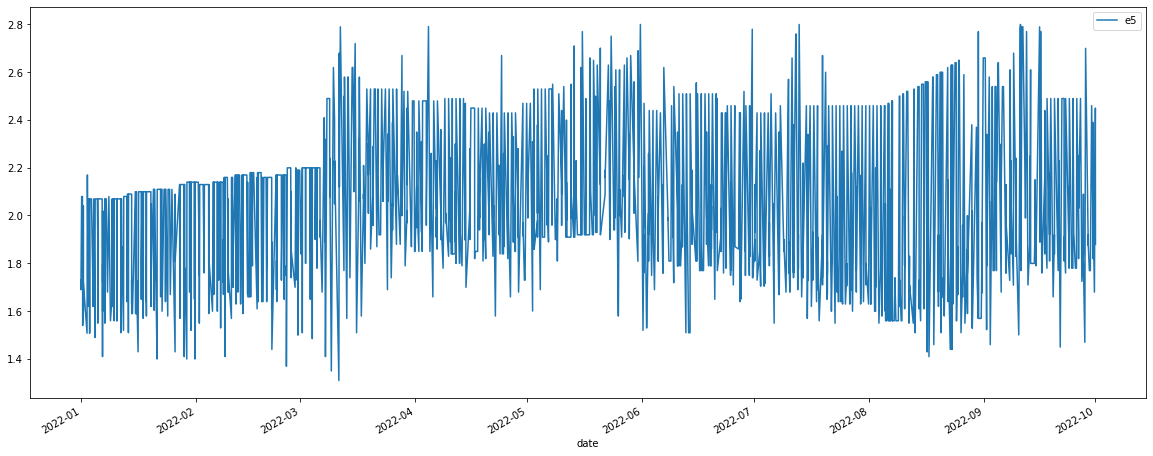

In [22]:
# M4 sampling and time series plot
from hana_ml.visualizers.m4_sampling import m4_sampling
fuelprice_sample=m4_sampling(fuelprice_all_hdf.select('date', 'e5'), 210)


fuelprice_sample_pd=fuelprice_sample.collect()
fuelprice_sample_pd.set_index(fuelprice_sample_pd.columns[0], inplace=True)
fuelprice_sample_pd.sort_index(inplace=True)
fuelprice_sample_pd=fuelprice_sample_pd.astype(float)
 
ax = fuelprice_sample_pd.plot(figsize=(20,8))

<br>

Another time series aggregation plot is the monthly box-plot

<AxesSubplot:>

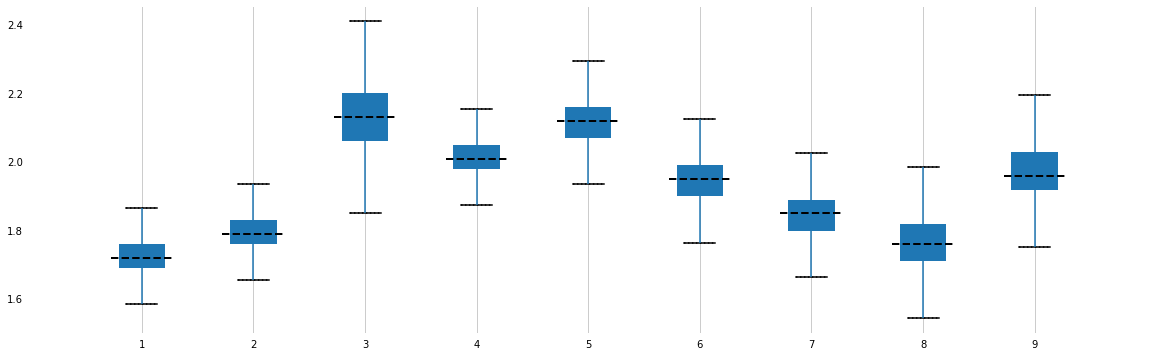

In [23]:
# timeseries_box_plot
from hana_ml.visualizers.eda import timeseries_box_plot
f = plt.figure(figsize=(20, 6))
timeseries_box_plot(data=fuelprice_sample, col="e5", key="date", cycle="MONTH")

# Exercise 5.3 - Forecast the fuel prices per station

In this section we now want to model one fuel price forecast for each gas station in parallel, also known as segmented forecasting approach. As the fuel price time series is not a simple auto-regressive time series, but is dependent on external factors (e.g. holidays) and other (incl. irregular) changepoints we will apply the Additive-Model-Analysis (aka prophet) forecasting method from the [Predictive Analysis Library (PAL)](https://help.sap.com/docs/HANA_CLOUD_DATABASE/319d36de4fd64ac3afbf91b1fb3ce8de/7e78d06c0e504789bcc32256d3f7f871.html?locale=en-US). This forecast method can be applied in massive-mode, invoking the segmented execution approach (forecast by gas station in parallel).

__Step 1 - Select the price data for the local region and time range__  
For a more focused analysis, we want to model forecast only for the 171 gas stations in the regional area around the SAP headquarters.

In [28]:
# Refelect number of service stations in local regrion close to SAP HQ
print("Number of Serice Stations in the Rhein-Neckar area", stations_rnk_hdf.count(), "\n")
#RAW_DATA
# Create a fuel price data HANA dataframe, filtering to local area stations using HANA spatial intersect-filtering
fuelprice_rnk_hdf=conn.sql(
"""
select "date", "station_uuid", "e5" 
    from "RAW_DATA"."GAS_PRICES" 
    WHERE "station_uuid" 
         IN (SELECT "uuid" 
              FROM (SELECT * FROM "GAS_STATIONS") AS S, 
                   (SELECT * FROM "GEO_GERMANY_REGIONS" 
                    WHERE "krs_name"=\'Landkreis Rhein-Neckar-Kreis\' or "krs_name"=\'Stadtkreis Heidelberg\' 
                          or "krs_name"=\'Stadtkreis Mannheim\' ) AS G 
              WHERE "longitude_latitude_GEO".ST_SRID(25832).st_transform(25832).st_intersects(SHAPE)=1);
"""
)
display(fuelprice_rnk_hdf.collect())

Number of Serice Stations in the Rhein-Neckar area 171 



,date,station_uuid,e5
0,2022-08-15 17:37:08,0c7e5731-68c4-49f9-bcbc-87dbaa191294,1.749
1,2022-08-16 13:30:09,0c7e5731-68c4-49f9-bcbc-87dbaa191294,1.749
2,2022-08-15 13:33:09,0c7e5731-68c4-49f9-bcbc-87dbaa191294,1.749
3,2022-08-16 17:11:07,2645b215-8233-49dc-85f4-b389b284f624,1.749
4,2022-08-15 19:28:09,4e4f2acc-722d-4eb6-a71d-5c17bc5d5fe3,1.749
...,...,...,...
963519,2022-09-30 15:16:12,9f553817-0018-408c-9c23-4f5686419f5a,1.899
963520,2022-09-30 15:16:12,c080d550-c6ce-46d2-bc99-af48136c3ada,1.869
963521,2022-09-30 15:16:12,fb706efa-ebbc-406e-bef7-6c0c9ab205bd,1.909
963522,2022-09-30 15:16:12,63b7f9e0-8cd0-4016-baa6-9d7d77328070,1.829


Next, we want to sample the last week period of our time series fuel price data  as our time series test data, to evaluate the forecast quality.

In [29]:
# Identifying the first and last data of our time series
print( "The dataset covers the time period starting from: ")
print( fuelprice_rnk_hdf.sort('date').select('date').head(1).collect(), "\n")
print( "... and ends at: ")
print( fuelprice_rnk_hdf.sort('date', desc=True).select('date').head(1).collect())

The dataset covers the time period starting from: 
                 date
0 2022-01-01 00:02:17 

... and ends at: 
                 date
0 2022-09-30 23:32:06


<br>

Based on the time series range, we now create 3 time series dataframes
- __train_rnk_hdf__ containing all price values up until the 2nd last week of the series
- __test_groundtruth_rnk_hdf__ containing the price values of the last week
- __test_rnk_hdf__ containing empty price values for our test series time values

In [30]:
# in order to predict the last 7 days, we restict our training data to be earlier than 2022-09-23
train_rnk_hdf  = fuelprice_rnk_hdf.filter('"date" < \'2022-09-23 00:00:00.000\'')

# ground truth
test_groundtruth_rnk_hdf  = fuelprice_rnk_hdf.filter('"date" >= \'2022-09-23 00:00:00.000\'')

# create test dataset, same as ground truth only target column values set to 0
test_rnk_hdf = test_groundtruth_rnk_hdf.drop(['e5'])
test_rnk_hdf = test_rnk_hdf.add_constant('e5', 0)
test_rnk_hdf = test_rnk_hdf.cast('e5', 'DOUBLE')

#test_groundtruth_rnk_hdf.sort('date').head(3).collect()
print('Number of forecast training rows', train_rnk_hdf.count())
print('Number of forecast testing rows', test_rnk_hdf.count())

Number of forecast training rows 934157
Number of forecast testing rows 29367


<br>  

__Step 2 - Model the fuel price forecast__  
The Additive-Model-Analysis (aka prophet) forecasting method allows to add external factor and changepoint information as input to the analysis. Hence it requires us to pass-in a respective table or dataframe with the analysis. We use the dataframe create_table-method, to create the empty holiday-data needed.

In [32]:
# Prepare holiday data table (for simplicity an empty table) for the forecast model function
conn.create_table(
    table='PAL_ADDITIVE_MODEL_ANALYSIS_HOLIDAY',
    schema='TECHED_USER_999',
    table_structure={'GROUP_IDXXX': 'INTEGER', 'ts': 'TIMESTAMP', 'NAME': 'VARCHAR(255)', 
                     'LOWER_WINDOW': 'INTEGER', 'UPPER_WINDOW': 'INTEGER'})
holiday_data_hdf = conn.sql('select * from "TECHED_USER_999"."PAL_ADDITIVE_MODEL_ANALYSIS_HOLIDAY"')

<br>

Now we instantiate and execute the actual Additive-Model-Analysis forecast training (fit) method, in parallel for each station using the "massive=True" parameter.

In [33]:
# Build a forecast model per station in parallel using PAL Additive Model Forecast (aka Prophet)-forecasting function
from hana_ml.algorithms.pal.tsa.additive_model_forecast import AdditiveModelForecast

amf = AdditiveModelForecast(massive=True,growth='linear',
                                changepoint_prior_scale=0.06,
                                weekly_seasonality='True',
                                daily_seasonality='True'
                                )

amf.fit(data=train_rnk_hdf, key="date", group_key="station_uuid", holiday=holiday_data_hdf)

amf.runtime

174.79901361465454

The forecast model training for all 171-gas station forecast models.  
<br>  
  
Which SQL statement was actually executed in SAP HANA? The AdditiveModelForecast method, like any other PAL function in the Python Machine Learning clients, provides methods (here: get_fit_execute_statement) to retrieve information about the executed statements, parameters and objects involved.

In [34]:
print(amf.get_fit_execute_statement())
#print(conn.last_execute_statement)

DO
BEGIN
DECLARE group_id NVARCHAR(100) ARRAY;
DECLARE param_name VARCHAR(5000) ARRAY;
DECLARE int_value INTEGER ARRAY;
DECLARE double_value DOUBLE ARRAY;
DECLARE string_value VARCHAR(5000) ARRAY;
group_id[1] := N'PAL_MASSIVE_PROCESSING_SPECIAL_GROUP_ID';
param_name[1] := N'GROWTH';
int_value[1] := NULL;
double_value[1] := NULL;
string_value[1] := N'linear';
group_id[2] := N'PAL_MASSIVE_PROCESSING_SPECIAL_GROUP_ID';
param_name[2] := N'WEEKLY_SEASONALITY';
int_value[2] := 1;
double_value[2] := NULL;
string_value[2] := NULL;
group_id[3] := N'PAL_MASSIVE_PROCESSING_SPECIAL_GROUP_ID';
param_name[3] := N'DAILY_SEASONALITY';
int_value[3] := 1;
double_value[3] := NULL;
string_value[3] := NULL;
group_id[4] := N'PAL_MASSIVE_PROCESSING_SPECIAL_GROUP_ID';
param_name[4] := N'CHANGEPOINT_PRIOR_SCALE';
int_value[4] := NULL;
double_value[4] := 0.06;
string_value[4] := NULL;
params = UNNEST(:group_id, :param_name, :int_value, :double_value, :string_value);
in_0 = SELECT "station_uuid", "date", "e5" FR

<br>  

How do the AdditiveModelAnalysis segmented models look like?  
We can collect the returned "model_"-dataframe from the forecast-fit call.

In [35]:
# How do the AdditiveModelAnalysis segmented model look like?
pd.set_option('max_colwidth', None)
df=amf.model_.head(5).collect()

display(df.style.set_properties(**{'text-align': 'left'}))

,GROUP_ID,ROW_INDEX,MODEL_CONTENT
0,0e64e4c6-3d58-44d4-bbe5-377a5a0db2f2,0,"{""GROWTH"":""linear"",""FLOOR"":0.0,""SEASONALITY_MODE"":""additive"",""start"":""2022-01-01 07:04:21.0000000"",""y_scale"":2.279,""t_scale"":22858068.0,""cat_field_moments"":"""",""seasonality_name"":[[""daily"",""weekly""]],""seasonality_period"":[[1.0,7.0]],""seasonality_fourier_order"":[[4.0,3.0]],""seasonality_prior_scale"":[[10.0,10.0]],""seasonality_mode"":[[0,0]],""k"":0.16905147208419855,""m"":0.6747837028704113,""delta"":[[0.000019855436480770303,-0.003139637662435646,0.01679415930537439,-0.0328133049267626,-0.27360721610263186,2.2353936376905745,1.7666466807584179,-4.576067679116404,-0.15681888747492085,-0.00033573103873196276,0.14485727184034406,1.0586197528280708,-0.0024972567359713238,0.0260837738311591,0.0481478819212962,0.0014836234780521848,-2.321147927061606,1.6709063034691847,0.005396985160030785,-0.3910978524193159,-0.006825204880160806,0.09470872093528066,-0.004691954762746377,-0.23052082667237665,1.3019344966827458]],""sigma_obs"":0.02173282163421346,""beta"":[[-0.0118323992058886,-0.12673192273546173,-0.04951517181024579,-0.09912837289110321,-0.054766086948141317,-0.038751734885562449,-0.022701901282780634,-0.002764645255531139,0.0021537149845288377,-0.005134606278153353,-0.0013161485774701354,0.001050481542735515,0.001886375127655609,-0.00025728681794776314]],""changepoints_t"":[[0.03126209091687014,0.06575043875099156,0.09877418336492831,0.1304356081187614,0.16397129451185464,0.19373758972105604,0.22760676886603016,0.2589504064822976,0.29206615362243218,0.3233075953750772,0.3549848132396841,0.3834701165470328,0.415908553601293,0.4476277697660187,0.48019228921709397,0.5084229778299724,0.5418090890271217,0.5747145821772863,0.6065861734246306,0.6398645764812669,0.6769385321629107,0.708321761926686,0.7428654075226305,0.776311803779742,0.809537752709459]],""holidays_prior_scale"":10.0}"
1,0e5f8257-c5e6-44f2-8d7f-4ba90f7b9646,0,"{""GROWTH"":""linear"",""FLOOR"":0.0,""SEASONALITY_MODE"":""additive"",""start"":""2022-01-01 00:06:11.0000000"",""y_scale"":2.349,""t_scale"":22882198.0,""cat_field_moments"":"""",""seasonality_name"":[[""daily"",""weekly""]],""seasonality_period"":[[1.0,7.0]],""seasonality_fourier_order"":[[4.0,3.0]],""seasonality_prior_scale"":[[10.0,10.0]],""seasonality_mode"":[[0,0]],""k"":0.051652180310456017,""m"":0.735176843058311,""delta"":[[0.00001600939299196334,0.09291902580088094,0.16143389256818153,-0.000027265509194837965,-0.33404783415902919,2.062016868311476,1.046102165345993,-4.461597356943375,0.7168997458255622,0.09555097254853488,0.4165569526017304,0.40940346985828565,0.026480456080889528,0.23051449880173167,0.19022212727265018,-0.6455275264640256,-1.3831263206901064,0.7708832558403918,0.003384549901830661,-0.14229914520585788,0.040149843214075737,0.11228748656162813,-0.0006325271997385875,-0.30237272121092298,1.4015066283961622]],""sigma_obs"":0.02337325903132265,""beta"":[[0.029527925353901409,-0.006715066273355299,0.006555785427283219,-0.009862643631695454,0.002307965245686061,-0.002608988762988435,0.0036138814424708685,-0.0016114232947575718,-0.002351028457307764,0.004021637433438979,0.003648674141465862,-0.002202558412935778,0.00042237002978908573,0.001325286109493763]],""changepoints_t"":[[0.03223881726746705,0.06256112284318141,0.09593558276176091,0.12997339678644508,0.1634500759061695,0.19515411063220412,0.22899277420814208,0.26688777887508888,0.3001756212405819,0.33117430414683066,0.3618847280318088,0.3941237201076575,0.4252509308764831,0.4544303829553437,0.4825155782674374,0.5128037962087384,0.5449589239635109,0.5721004162274971,0.6024936503040486,0.6332642519743951,0.6637621088673387,0.700456223654738,0.734394396901906,0.7653195291815935,0.7993836518677095]],""holidays_prior_scale"":10.0}"
2,018e8f3e-ae2f-40bc-89c1-bc3fe20eb462,0,"{""GROWTH"":""linear"",""FLOOR"":0.0,""SEASONALITY_MODE"":""additive"",""start"":""2022-01-01 00:02:17.0000000"",""y_scale"":2.289,""t_scale"":22883512.0,""cat_field_

<br>

__Step 3 - Forecast prediction and visualization__  
We now want to apply the trained forecast model for each station and __predict price values for the test period__ and visualize it all.  The AdditiveModelForecast-predict method applies station-specific forecast model to the test_rnk_hdf-dataframe. 

In [36]:
# The AdditiveModelForecast-PREDICT method returns an array of three dataframes.
fc_result, fc_decomp, fc_error = amf.predict(data=test_rnk_hdf, key="date", group_key="station_uuid")

#print(amf.get_predict_execute_statement())

# look at forecast result data
display(fc_result.head(3).collect())

# Look the time series decomposition result data
display(fc_decomp.head(3).collect())

# Check for errors in any of the station_uuids
display(fc_error.head(3).collect())

C:\Users\D059078\AppData\Local\Continuum\anaconda3\lib\site-packages\hana_ml\algorithms\pal\tsa\additive_model_forecast.py:466: UserWarning: For group_key '3ec1e50e-aba5-436c-960a-423b2b8a37ed', the error message is 'PAL error[73001570]: $ERROR$. unsupported timestamp type, only support TIMESTAMP, SECONDDATE, DATE'.More information could be seen in the 2nd return Dataframe!
  warnings.warn(message=warn_msg)
C:\Users\D059078\AppData\Local\Continuum\anaconda3\lib\site-packages\hana_ml\algorithms\pal\tsa\additive_model_forecast.py:466: UserWarning: For group_key '51d4b58a-a095-1aa0-e100-80009459e03a', the error message is 'PAL error[73001570]: $ERROR$. unsupported timestamp type, only support TIMESTAMP, SECONDDATE, DATE'.More information could be seen in the 2nd return Dataframe!
  warnings.warn(message=warn_msg)


,GROUP_ID,date,YHAT,YHAT_LOWER,YHAT_UPPER
0,0e64e4c6-3d58-44d4-bbe5-377a5a0db2f2,2022-09-23 05:04:10,2.009896,1.948501,2.069392
1,0e64e4c6-3d58-44d4-bbe5-377a5a0db2f2,2022-09-23 05:14:09,2.033716,1.972935,2.095515
2,0e64e4c6-3d58-44d4-bbe5-377a5a0db2f2,2022-09-23 07:32:09,2.004993,1.940057,2.067411


,GROUP_ID,date,TREND,SEASONAL,HOLIDAY,EXOGENOUS
0,0e64e4c6-3d58-44d4-bbe5-377a5a0db2f2,2022-09-23 05:04:10,1.772643,"{""seasonalities"":0.2372526575040062}",{},{}
1,0e64e4c6-3d58-44d4-bbe5-377a5a0db2f2,2022-09-23 05:14:09,1.772676,"{""seasonalities"":0.26104004850393577}",{},{}
2,0e64e4c6-3d58-44d4-bbe5-377a5a0db2f2,2022-09-23 07:32:09,1.773122,"{""seasonalities"":0.2318708680755666}",{},{}


,GROUP_ID,ERROR_TIMESTAMP,ERRORCODE,MESSAGE
0,3ec1e50e-aba5-436c-960a-423b2b8a37ed,2022-10-14 14:18:05.986213,73001570,"PAL error[73001570]: $ERROR$. unsupported timestamp type, only support TIMESTAMP, SECONDDATE, DATE"
1,51d4b58a-a095-1aa0-e100-80009459e03a,2022-10-14 14:18:06.636169,73001570,"PAL error[73001570]: $ERROR$. unsupported timestamp type, only support TIMESTAMP, SECONDDATE, DATE"


Note a warning message might be given if there is no predict input-data for selected stations (group-ids). You could apply the print(amf.get_predict_execute_statement())-call to review the execute SQL statement for the predict call.  
<br>
Now, we want to __visualize the forecast data__ for a selected station

In [37]:
#Set a station variable for data filtering
station='018e8f3e-ae2f-40bc-89c1-bc3fe20eb462'

# Filter forecast train data (actuals) for station
act_train_1s=train_rnk_hdf.filter('"station_uuid" = \'{}\''.format(station)).sort('date', desc=False)
act_train_1s=act_train_1s.drop('station_uuid').rename_columns({'e5': 'ACTUAL'})
#act_train_1s.head(2).collect()

# Filter test data ground thruth (actuals) for station
act_gt_1s=test_groundtruth_rnk_hdf.filter('"station_uuid" = \'{}\''.format(station)).sort('date', desc=False)
act_gt_1s=act_gt_1s.drop('station_uuid').rename_columns({'e5': 'E5_ACTUAL'})
#act_gt_1s.head(2).collect()

# Union actuals into one set
actual_1s=act_train_1s.union(act_gt_1s).sort('date')
display(actual_1s.head(10).collect())

# Filter forecast predictions
forecast_1s=fc_result.filter('"GROUP_ID" = \'{}\''.format(station)).sort('date', desc=False)
forecast_1s=forecast_1s.select('date', 'YHAT', 'YHAT_LOWER', 'YHAT_UPPER').rename_columns({'YHAT': 'PREDICTED'})
display(forecast_1s.head(2).collect())

,date,ACTUAL
0,2022-01-01 00:02:17,1.749
1,2022-01-01 07:01:08,1.779
2,2022-01-01 09:02:18,1.829
3,2022-01-01 09:45:28,1.779
4,2022-01-01 10:10:11,1.729
5,2022-01-01 12:01:10,1.779
6,2022-01-01 12:11:08,1.779
7,2022-01-01 12:40:07,1.719
8,2022-01-01 13:31:15,1.709
9,2022-01-01 13:52:11,1.689


,date,PREDICTED,YHAT_LOWER,YHAT_UPPER
0,2022-09-23 05:01:09,2.010863,1.949658,2.068862
1,2022-09-23 07:46:09,1.955674,1.894689,2.016800


<br>  


Using the hana-ml Forecast-Lineplot visualization for the complete time period of data

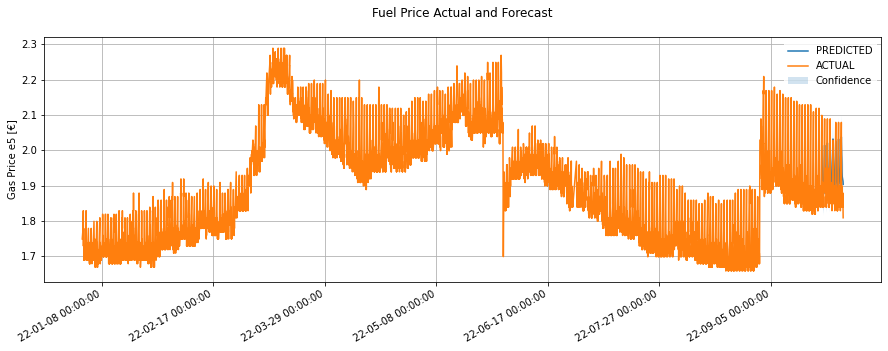

In [38]:
# Forecast-Lineplot for the complete period
from hana_ml.visualizers.visualizer_base import forecast_line_plot
ax = forecast_line_plot(actual_data=actual_1s.set_index("date"),
                        pred_data=forecast_1s.set_index("date"),                
                    confidence=("YHAT_LOWER", "YHAT_UPPER"),
                    max_xticklabels=10, figsize=(15, 5))

ax.set_title('Fuel Price Actual and Forecast', pad=20)
plt.ylabel('Gas Price e5 [€]')
plt.show()

<br>  


Let's plot another forecast visualization, more focused on the weeks at the end of the time series.

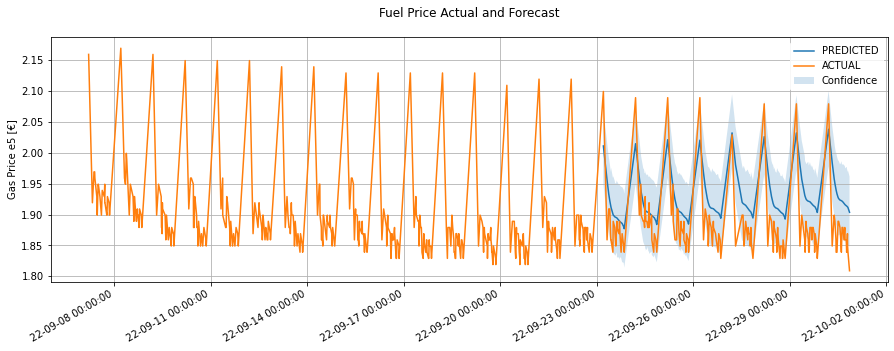

In [39]:
# Forecast-Lineplot for the last 3 weeks of data
from hana_ml.visualizers.visualizer_base import forecast_line_plot
ax = forecast_line_plot(pred_data=forecast_1s.set_index("date"),
                    actual_data=actual_1s.filter('"date" >= \'2022-09-07 00:00:00.000\'').set_index("date"),
                    confidence=("YHAT_LOWER", "YHAT_UPPER"),
                    max_xticklabels=10, figsize=(15, 5))

ax.set_title('Fuel Price Actual and Forecast', pad=20)
plt.ylabel('Gas Price e5 [€]')
plt.show()

## Add-on (optional) - Evaluate Forecast Accuracy


In order to evaluate the forecast accuracy for each stations's model, we need to comparing predicted forecast values (from the predict-results) with the actual ground-truth e5-values of the test data time period.

In [40]:
# Comparing predicted Forecast with observed ground-truth e5-values of the test data time period

# Prepare a dataframe with the forecast predictions
fc_allgroups=fc_result.select('date', 'GROUP_ID', 'YHAT', 'YHAT_LOWER', 'YHAT_UPPER').rename_columns({'YHAT': 'PREDICTED'})

# Prepare a dataframe with the actual groundtruth values
act_allgroups=test_groundtruth_rnk_hdf.sort('date', desc=True).rename_columns({'e5': 'ACTUAL'})

# Join actual and predicted values in a new dataframe
testacc_allgroups=act_allgroups.alias('A').join(fc_allgroups.alias('F'), 
          'A."station_uuid"=F."GROUP_ID" and A."date" = F."date"',
          select=['station_uuid', ('A."date"', 'DATE'), 'ACTUAL', 'PREDICTED']).sort('DATE')
testacc_allgroups=testacc_allgroups.sort('DATE')
 
display(testacc_allgroups.head(10).collect())

,station_uuid,DATE,ACTUAL,PREDICTED
0,aab0ca78-c465-4f09-9307-c9739c814516,2022-09-23 00:34:09,1.929,1.986540
1,1dc632bf-90c5-4971-8420-a74a842203c1,2022-09-23 00:34:09,1.919,1.997717
2,417722f4-761a-4e8e-a750-104aef3181df,2022-09-23 00:36:05,1.979,1.951235
3,b6a3937b-bc37-43d4-b206-c31d6bb74300,2022-09-23 00:44:09,1.899,2.006659
4,16c7cc25-cfdf-4e18-81b3-90d7f17f35fe,2022-09-23 03:55:10,1.919,1.964504
5,cbce0ea0-12da-4e3a-a42d-af57bee17ce7,2022-09-23 04:14:09,1.819,1.935188
6,ce8820a8-1968-404c-9072-fd3a32d7c61d,2022-09-23 04:54:09,2.109,2.073659
7,a3b3f1e3-9bb8-4869-88b3-ef0238de18e2,2022-09-23 05:01:09,2.139,2.112500
8,f68ad3b1-44c2-47b0-ba9b-eb23163b7ee3,2022-09-23 05:01:09,2.139,2.102763
9,80cc039e-493e-4b2b-a9e0-1044b6c63329,2022-09-23 05:01:09,2.139,2.102726


<br>


In order to store the forecast accuracy values for each station, we are preparing a table to store the data.

In [41]:
# Create a Forecast accuracy-measures table
conn.create_table(table='FORECAST_ACCURACY',schema='TECHED_USER_999', 
                 table_structure={'station_uuid': 'NVARCHAR(5000)', 'STAT_NAME': 'NVARCHAR(10)', 'STAT_VALUE': 'DOUBLE'})
fc_acc=conn.table('FORECAST_ACCURACY')
#fc_acc.count()

0

<br>  

Finally, we caculate the forecast accuracy measture, iterating over each of the 171 gas stations and appending the values to the table previously created.

In [43]:
# Get alls stations uuids into a list
df=testacc_allgroups.distinct('station_uuid').collect()
stations_all=list(set(list(df['station_uuid'])))
#print(stations_all)

# Calculate Forecast Accuracy Measure for each station 
from hana_ml.algorithms.pal.tsa.accuracy_measure import accuracy_measure
amres = {}
for station in stations_all:
    amres[station] = accuracy_measure(data=testacc_allgroups.filter('"station_uuid"=\'{}\''.format(station)
                                                                   ).select(['ACTUAL', 'PREDICTED']),
                                      evaluation_metric=['mse', 'rmse', 'mpe', 'et',
                                                         'mad', 'mase', 'wmape', 'smape',
                                                         'mape'])
   
    amres[station]=amres[station].select(('\'{}\''.format(station),'station_uuid'), 'STAT_NAME', 'STAT_VALUE')
    amres[station].save('FORECAST_ACCURACY', append=True)
    
fc_acc.collect()

,station_uuid,STAT_NAME,STAT_VALUE
0,e877c9b1-c5cb-4e54-8854-9e47f7e28b64,ET,-25.553871
1,e877c9b1-c5cb-4e54-8854-9e47f7e28b64,MAD,0.113218
2,e877c9b1-c5cb-4e54-8854-9e47f7e28b64,MAPE,0.060044
3,e877c9b1-c5cb-4e54-8854-9e47f7e28b64,MASE,3.547714
4,e877c9b1-c5cb-4e54-8854-9e47f7e28b64,MPE,-0.058815
...,...,...,...
1399,db62384b-f8db-47d9-baca-9dbdf561d661,MPE,-0.039418
1400,db62384b-f8db-47d9-baca-9dbdf561d661,MSE,0.006865
1401,db62384b-f8db-47d9-baca-9dbdf561d661,RMSE,0.082854
1402,db62384b-f8db-47d9-baca-9dbdf561d661,SMAPE,0.040250


## Add-on (optional)  -  Execute forecast on new Data

In [ ]:
# load Data from last week, yesterday, ...
# -- retrain forecast
# -- forecast next 7 days

# Reference

The __gas station and fuel price data__ is published on the public website [Tankerkönig](http://www.tankerkoenig.de/). This dataset contains the gas prices of all gas stations in Germany from 2014 until today as csv files. A record contains the station id, the datetime, prices for diesel, e5 and e10 and a change indicator. In a separate csv the data of the service stations including its geolocation is provided.

The data used along with the exercises is thereas used only for the purpose of your personal education. For non-commercial use the data is availble with the following license agreement https://creativecommons.org/licenses/by-nc-sa/4.0/.

The __German "Landkreise"-regional geo data__ is shared and can be downloaded from [data.opendatasoft.com/georef-germany-kreis](https://data.opendatasoft.com/explore/dataset/georef-germany-kreis%40public/export/?disjunctive.lan_code&disjunctive.lan_name&disjunctive.krs_code&disjunctive.krs_name&disjunctive.krs_name_short!%5Bimage.png%5D(attachment:image.png)&disjunctive.krs_name_short). This dataset is licensed under the "Data licence Germany – attribution – version 2.0", see https://www.govdata.de/dl-de/by-2-0 and allowed for commercial and non-commercial use under reference of the license.